In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')
import cv2

In [2]:
!rm -rf pred

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [4]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
 99% 83.0M/84.0M [00:05<00:00, 21.7MB/s]
100% 84.0M/84.0M [00:05<00:00, 14.9MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-detection.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
folder = '/content/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print(count)

1501


In [7]:
folder = '/content/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count) + ".jpg"
  os.rename(source, destination)
  count+=1
print(count)

1501


In [8]:
listyes=os.listdir("/content/yes/")
number_files_yes=len(listyes)
print(number_files_yes)

listno=os.listdir("/content/no/")
number_files_no=len(listno)
print(number_files_no)

1500
1500


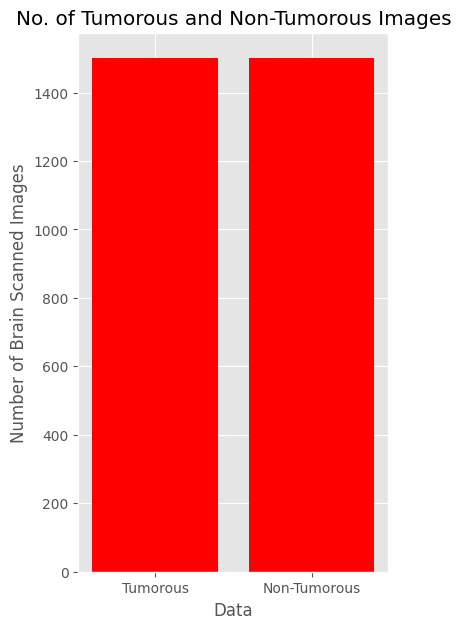

In [9]:
data={'Tumorous' : number_files_yes, 'Non-Tumorous' : number_files_no}

keys=data.keys()
values=data.values()

fig=plt.figure(figsize=(4,7))
plt.bar(keys, values, color="Red")

plt.xlabel("Data")
plt.ylabel("Number of Brain Scanned Images")
plt.title("No. of Tumorous and Non-Tumorous Images")
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
def timing(sec_elapsed):
  h=sec_elapsed//(60*60)
  m=sec_elapsed % (60*60) // 60
  s=sec_elapsed%60
  return f"{h}:{m}:{s}"

In [12]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
  data_gen=ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      brightness_range=(0.3,1.0),
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

  batch=os.listdir(file_dir)[0:350]
  for filename in batch:
    image=cv2.imread(file_dir+'/'+filename)
    image=image.reshape((1,)+image.shape)
    save_prefix='aug_'+filename[:-4]
    i=0
    for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format='jpg'):
      i+=1
      if i>n_generated_samples:
        break

In [14]:
import time
start_time=time.time()

yes_path='/content/yes'
no_path='/content/no'

augmented_data_path='/content/augmented_data/'

augmented_data(file_dir=yes_path, n_generated_samples=3, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir=no_path, n_generated_samples=3, save_to_dir=augmented_data_path+'no')

end_time=time.time()
execution_time=(end_time-start_time)
print(f"Elapsed time: {timing(execution_time)}")

Elapsed time: 0.0:1.0:33.885775327682495


In [15]:
def data_summary(main_path):
  yes_path="/content/augmented_data/yes/"
  no_path="/content/augmented_data/no/"

  n_pos=len(os.listdir(yes_path))
  n_neg=len(os.listdir(no_path))

  n=n_pos+n_neg

  pos_per=(n_pos*100)/n
  neg_per=(n_neg*100)/n

  print(f"Number of sample: {n}")
  print(f"Percentage of positive samples: {pos_per}%")
  print(f"Percentage of negative samples: {neg_per}%")
  print(f"Number of positive samples: {n_pos}")
  print(f"Number of negative samples: {n_neg}")

In [16]:
data_summary(augmented_data_path)

Number of sample: 2800
Percentage of positive samples: 50.0%
Percentage of negative samples: 50.0%
Number of positive samples: 1400
Number of negative samples: 1400


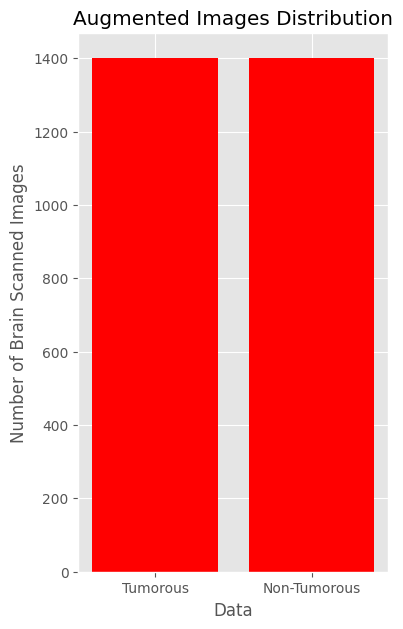

In [17]:
data={'Tumorous': len(os.listdir('/content/augmented_data/yes/')), 'Non-Tumorous': len(os.listdir('/content/augmented_data/no/'))}
key=data.keys()
value=data.values()

fig=plt.figure(figsize=(4,7))
plt.bar(key, value, color="Red")

plt.xlabel("Data")
plt.ylabel("Number of Brain Scanned Images")
plt.title("Augmented Images Distribution")
plt.show()

In [18]:
import imutils
def crop_brain_tumor(image, plot=False):
  gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray=cv2.GaussianBlur(gray, (5,5), 0)

  thres=cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thres=cv2.erode(thres, None, iterations=2)
  thres=cv2.dilate(thres, None, iterations=2)

  cnts=cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts=imutils.grab_contours(cnts)
  c=max(cnts, key=cv2.contourArea)

  extLeft=tuple(c[c[:,:,0].argmin()][0])
  extRight=tuple(c[c[:,:,0].argmax()][0])
  extTop=tuple(c[c[:,:,1].argmin()][0])
  extBot=tuple(c[c[:,:,1].argmax()][0])

  new_image=image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both',
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False,labelright=False)

    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both',
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    plt.show()

  return new_image



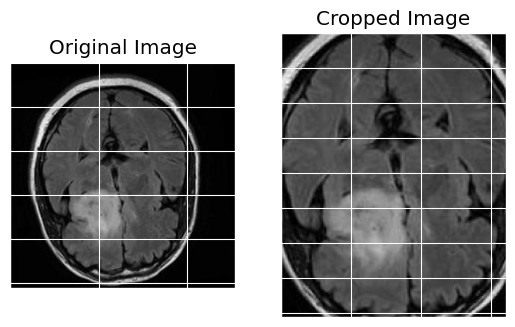

array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)
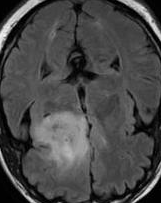

In [20]:
img=cv2.imread('/content/augmented_data/yes/aug_Y_1012_0_5099.jpg')
crop_brain_tumor(img, plot=True)


In [21]:
folder_no='/content/augmented_data/no/'
folder_yes='/content/augmented_data/yes/'

for filename in os.listdir(folder_no):
  img=cv2.imread(folder_no+filename)
  img=crop_brain_tumor(img, False)
  cv2.imwrite(folder_no+filename, img)

for filename in os.listdir(folder_yes):
  img=cv2.imread(folder_yes+filename)
  img=crop_brain_tumor(img, False)
  cv2.imwrite(folder_yes+filename, img)



In [22]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
  x=[]
  y=[]

  image_width, image_height=image_size

  for directory in dir_list:
    for filename in os.listdir(directory):
      image=cv2.imread(directory+'/'+filename)
      image=crop_brain_tumor(image, plot=False)
      image=cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
      image=image/255.0
      x.append(image)
      if directory[-3:]=='yes':
        y.append(1)
      else:
        y.append(0)

  x=np.array(x)
  y=np.array(y)
  x,y=shuffle(x,y)
  print(f"Numer of Images : {len(x)}")

  return x,y



0

In [23]:
import os
import cv2
augmented_path='/content/augmented_data/'
augmented_yes=augmented_path+'yes'
augmented_no=augmented_path+'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

x,y=load_data([augmented_no, augmented_yes], (IMAGE_WIDTH, IMAGE_HEIGHT))


Numer of Images : 2800


In [24]:
def plot_sample_images(x, y, n=20):
  for label in [0,1]:
    images=x[np.argwhere(y==label)]
    n_images=images[:n]

    columns_n=5
    rows_n=int(n/columns_n)

    plt.figure(figsize=(15,10))

    i=1
    for image in n_images:
      plt.subplot(rows_n, columns_n, i)
      plt.imshow(image[0])

      plt.tick_params(axis='both', which='both',
                      top=False, bottom=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)
      i+=1

    label_to_str=lambda label: "Tumorous" if label==1 else "Non-Tumorous"
    plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
    plt.show()

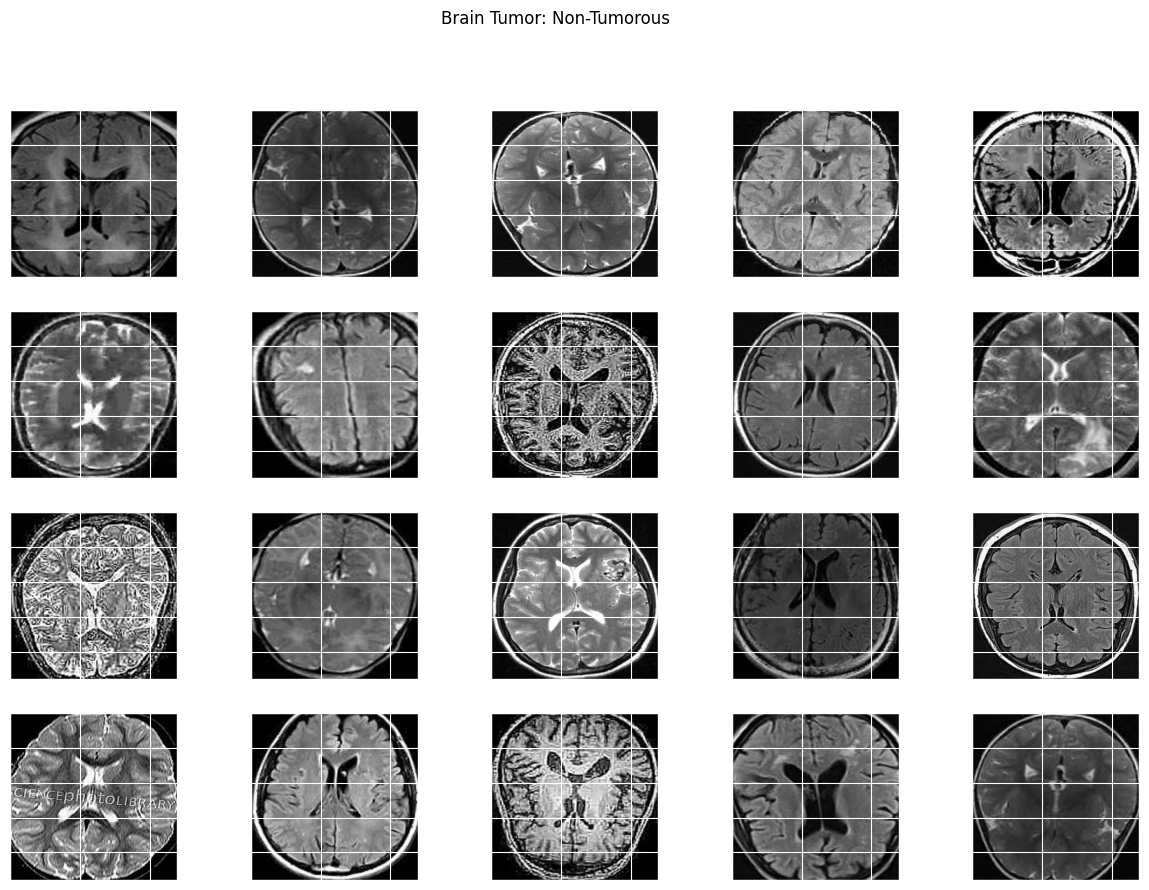

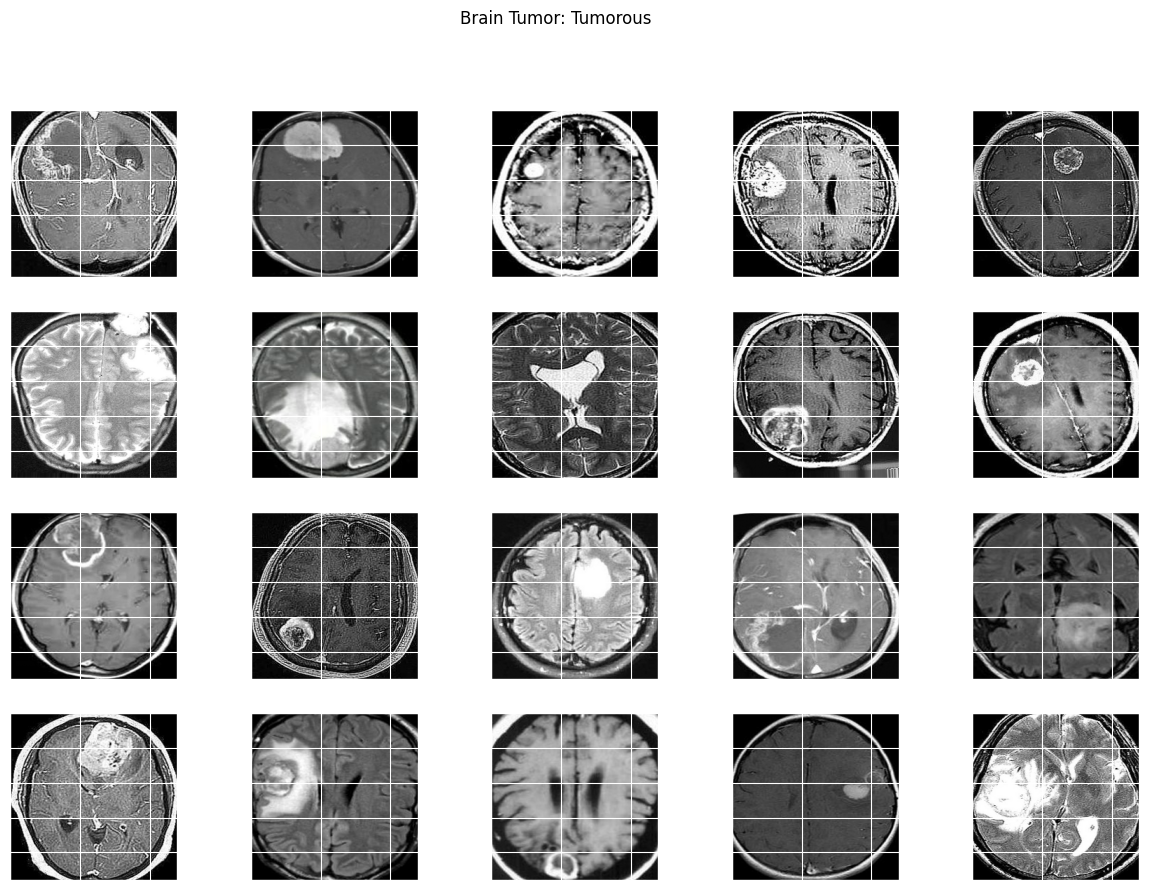

In [25]:
plot_sample_images(x, y)

In [27]:
files=os.listdir('/content/augmented_data/yes/')
fnames=[]
for i in range(0,1260):
  fnames.append(files[i])
for fname in fnames:
  src=os.path.join('/content/augmented_data/yes/', fname)
  dst=os.path.join('/content/train/tumorous/', fname)
  shutil.copyfile(src, dst)

In [29]:
files=os.listdir('/content/augmented_data/no/')
fnames=[]
for i in range(0,1260):
  fnames.append(files[i])
for fname in fnames:
  src=os.path.join('/content/augmented_data/no/', fname)
  dst=os.path.join('/content/train/non-tumorous/', fname)
  shutil.copyfile(src, dst)

In [30]:
files=os.listdir('/content/augmented_data/yes/')
fnames=[]
for i in range(1260, 1399):
  fnames.append(files[i])
for fname in fnames:
  src=os.path.join('/content/augmented_data/yes/', fname)
  dst=os.path.join('/content/valid/tumorous/', fname)
  shutil.copyfile(src, dst)

In [31]:
files=os.listdir('/content/augmented_data/no/')
fnames=[]
for i in range(1260, 1399):
  fnames.append(files[i])
for fname in fnames:
  src=os.path.join('/content/augmented_data/no/', fname)
  dst=os.path.join('/content/valid/non-tumorous/', fname)
  shutil.copyfile(src, dst)

In [32]:
import shutil

shutil.rmtree('/content/train/.ipynb_checkpoints')

In [33]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=0.4,
    vertical_flip=0.4,
    zoom_range=0.4,
    shear_range=0.2,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)

In [34]:
train_generator=train_datagen.flow_from_directory(
    '/content/train/',
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed = 42,
    color_mode = 'rgb')

Found 2520 images belonging to 2 classes.


In [35]:
shutil.rmtree('/content/valid/.ipynb_checkpoints')

In [36]:
valid_generator=train_datagen.flow_from_directory(
    '/content/valid/',
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed = 42,
    color_mode = 'rgb')

Found 278 images belonging to 2 classes.


In [37]:
class_labels=train_generator.class_indices
class_name={value: key for (key, value) in class_labels.items()}

In [38]:
class_name

{0: 'non-tumorous', 1: 'tumorous'}

In [39]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import RMSprop

In [40]:
conv_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(240,240,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [41]:
conv_base.trainable=True
set_trainable=False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [42]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [43]:
model=Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [44]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [45]:
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 880ms/step - accuracy: 0.6161 - loss: 0.6679 - val_accuracy: 0.7554 - val_loss: 0.5153
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 533ms/step - accuracy: 0.7451 - loss: 0.5048 - val_accuracy: 0.7986 - val_loss: 0.4310
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 551ms/step - accuracy: 0.8517 - loss: 0.3793 - val_accuracy: 0.8669 - val_loss: 0.3307
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 80s 526ms/step - accuracy: 0.8463 - loss: 0.3408 - val_accuracy: 0.8921 - val_loss: 0.2751
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 531ms/step - accuracy: 0.8726 - loss: 0.2947 - val_accuracy: 0.8813 - val_loss: 0.2753
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 548ms/step - accuracy: 0.8828 - loss: 0.2701 - val_accuracy: 0.9137 - val_loss: 0.2223
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 79s 521ms/step - accuracy: 0.9092 - loss: 0.2238 - val_accuracy: 0.9317 - val_loss: 0.2209
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 535ms/step - accuracy: 0.9062 - loss: 0.2319 - val_accuracy: 0.928

In [46]:
valid_pred=model.predict(valid_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step


In [48]:
valid=valid_pred.argmax(axis=1)

In [49]:
valid_loss, valid_accuracy=model.evaluate(valid_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.9489 - loss: 0.1401


In [50]:
valid_loss, valid_accuracy

(0.1465233862400055, 0.9496402740478516)

In [51]:
pred_img=[]
for file in os.listdir('/content/pred/'):
  pred_img.append(file)

In [52]:
len(pred_img)

60

In [53]:
base="/content/pred/"
for i in pred_img:
  image=cv2.imread(base+i)
  image=crop_brain_tumor(image, False)
  image=cv2.resize(image, dsize=(240,240), interpolation=cv2.INTER_CUBIC)
  image=image/255.0
  image=np.expand_dims(image, axis=0)
  pred=model.predict(image)
  pred_class=pred.argmax(axis=1)
  print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/ste

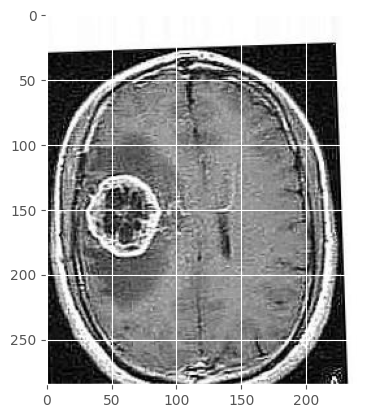

In [57]:
img='/content/augmented_data/yes/aug_Y_1064_0_1033.jpg'
image=cv2.imread(img)
plt.imshow(image)

In [58]:
image=crop_brain_tumor(image, False)
image=cv2.resize(image, dsize=(240,240), interpolation=cv2.INTER_CUBIC)
image=image/255.0
image=np.expand_dims(image, axis=0)
pred=model.predict(image)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[9.1025669e-07, 9.9999905e-01]], dtype=float32)

In [59]:
pred_class=pred.argmax(axis=1)
pred_class

array([1])

In [63]:
import pickle
filename='brain_tumor.pkl'
pickle.dump(model, open(filename, 'wb'))

In [66]:
model.save('brain_tumor_detect.keras')

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,640,710 (132.14 MB)

 Trainable params: 13,502,722 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 13,502,724 (51.51 MB)

In [64]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.0
Keras version: 3.4.1
